## **Homework 4**
**Instructions**
* This homework focuses on understanding and applying CoCoOp for CLIP prompt tuning. It consists of **four questions** designed to assess both theoretical understanding and practical application.

* Please organize your answers and results for the questions below and submit this jupyter notebook as **a .pdf file**.

* **Deadline: 11/26 (Sat) 23:59**

### **Preparation**

* Run the code below before proceeding with the homework.
* If an error occurs, click ‘Run Session Again’ and then restart the runtime from the beginning.

In [ ]:
!git clone https://github.com/mlvlab/ProMetaR.git
%cd ProMetaR/

!git clone https://github.com/KaiyangZhou/Dassl.pytorch.git
%cd Dassl.pytorch/

# Install dependencies
!pip install -r requirements.txt
!cp -r dassl ../
# Install this library (no need to re-build if the source code is modified)
# !python setup.py develop
%cd ..

!pip install -r requirements.txt

%mkdir outputs
%mkdir data

%cd data
%mkdir eurosat
!wget http://madm.dfki.de/files/sentinel/EuroSAT.zip -O EuroSAT.zip

!unzip -o EuroSAT.zip -d eurosat/
%cd eurosat
!gdown 1Ip7yaCWFi0eaOFUGga0lUdVi_DDQth1o

%cd ../../

import os.path as osp
from collections import OrderedDict
import math
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.cuda.amp import GradScaler, autocast
from PIL import Image
import torchvision.transforms as transforms
import torch
from clip import clip
from clip.simple_tokenizer import SimpleTokenizer as _Tokenizer
import time
from tqdm import tqdm
import datetime
import argparse
from dassl.utils import setup_logger, set_random_seed, collect_env_info
from dassl.config import get_cfg_default
from dassl.engine import build_trainer
from dassl.engine import TRAINER_REGISTRY, TrainerX
from dassl.metrics import compute_accuracy
from dassl.utils import load_pretrained_weights, load_checkpoint
from dassl.optim import build_optimizer, build_lr_scheduler

# custom
import datasets.oxford_pets
import datasets.oxford_flowers
import datasets.fgvc_aircraft
import datasets.dtd
import datasets.eurosat
import datasets.stanford_cars
import datasets.food101
import datasets.sun397
import datasets.caltech101
import datasets.ucf101
import datasets.imagenet
import datasets.imagenet_sketch
import datasets.imagenetv2
import datasets.imagenet_a
import datasets.imagenet_r

def print_args(args, cfg):
    print("***************")
    print("** Arguments **")
    print("***************")
    optkeys = list(args.__dict__.keys())
    optkeys.sort()
    for key in optkeys:
        print("{}: {}".format(key, args.__dict__[key]))
    print("************")
    print("** Config **")
    print("************")
    print(cfg)

def reset_cfg(cfg, args):
    if args.root:
        cfg.DATASET.ROOT = args.root
    if args.output_dir:
        cfg.OUTPUT_DIR = args.output_dir
    if args.seed:
        cfg.SEED = args.seed
    if args.trainer:
        cfg.TRAINER.NAME = args.trainer
    cfg.DATASET.NUM_SHOTS = 16
    cfg.DATASET.SUBSAMPLE_CLASSES = args.subsample_classes
    cfg.DATALOADER.TRAIN_X.BATCH_SIZE = args.train_batch_size
    cfg.OPTIM.MAX_EPOCH = args.epoch

def extend_cfg(cfg):
    """
    Add new config variables.
    """
    from yacs.config import CfgNode as CN
    cfg.TRAINER.COOP = CN()
    cfg.TRAINER.COOP.N_CTX = 16  # number of context vectors
    cfg.TRAINER.COOP.CSC = False  # class-specific context
    cfg.TRAINER.COOP.CTX_INIT = ""  # initialization words
    cfg.TRAINER.COOP.PREC = "fp16"  # fp16, fp32, amp
    cfg.TRAINER.COOP.CLASS_TOKEN_POSITION = "end"  # 'middle' or 'end' or 'front'
    cfg.TRAINER.COCOOP = CN()
    cfg.TRAINER.COCOOP.N_CTX = 4  # number of context vectors
    cfg.TRAINER.COCOOP.CTX_INIT = "a photo of a"  # initialization words
    cfg.TRAINER.COCOOP.PREC = "fp16"  # fp16, fp32, amp
    cfg.TRAINER.PROMETAR = CN()
    cfg.TRAINER.PROMETAR.N_CTX_VISION = 4  # number of context vectors at the vision branch
    cfg.TRAINER.PROMETAR.N_CTX_TEXT = 4  # number of context vectors at the language branch
    cfg.TRAINER.PROMETAR.CTX_INIT = "a photo of a"  # initialization words
    cfg.TRAINER.PROMETAR.PREC = "fp16"  # fp16, fp32, amp
    cfg.TRAINER.PROMETAR.PROMPT_DEPTH_VISION = 9  # Max 12, minimum 0, for 0 it will be using shallow IVLP prompting (J=1)
    cfg.TRAINER.PROMETAR.PROMPT_DEPTH_TEXT = 9  # Max 12, minimum 0, for 0 it will be using shallow IVLP prompting (J=1)
    cfg.DATASET.SUBSAMPLE_CLASSES = "all"  # all, base or new
    cfg.TRAINER.PROMETAR.ADAPT_LR = 0.0005
    cfg.TRAINER.PROMETAR.LR_RATIO = 0.0005
    cfg.TRAINER.PROMETAR.FAST_ADAPTATION = False
    cfg.TRAINER.PROMETAR.MIXUP_ALPHA = 0.5
    cfg.TRAINER.PROMETAR.MIXUP_BETA = 0.5
    cfg.TRAINER.PROMETAR.DIM_RATE=8
    cfg.OPTIM_VNET = CN()
    cfg.OPTIM_VNET.NAME = "adam"
    cfg.OPTIM_VNET.LR = 0.0003
    cfg.OPTIM_VNET.WEIGHT_DECAY = 5e-4
    cfg.OPTIM_VNET.MOMENTUM = 0.9
    cfg.OPTIM_VNET.SGD_DAMPNING = 0
    cfg.OPTIM_VNET.SGD_NESTEROV = False
    cfg.OPTIM_VNET.RMSPROP_ALPHA = 0.99
    cfg.OPTIM_VNET.ADAM_BETA1 = 0.9
    cfg.OPTIM_VNET.ADAM_BETA2 = 0.999
    cfg.OPTIM_VNET.STAGED_LR = False
    cfg.OPTIM_VNET.NEW_LAYERS = ()
    cfg.OPTIM_VNET.BASE_LR_MULT = 0.1
    # Learning rate scheduler
    cfg.OPTIM_VNET.LR_SCHEDULER = "single_step"
    # -1 or 0 means the stepsize is equal to max_epoch
    cfg.OPTIM_VNET.STEPSIZE = (-1, )
    cfg.OPTIM_VNET.GAMMA = 0.1
    cfg.OPTIM_VNET.MAX_EPOCH = 10
    # Set WARMUP_EPOCH larger than 0 to activate warmup training
    cfg.OPTIM_VNET.WARMUP_EPOCH = -1
    # Either linear or constant
    cfg.OPTIM_VNET.WARMUP_TYPE = "linear"
    # Constant learning rate when type=constant
    cfg.OPTIM_VNET.WARMUP_CONS_LR = 1e-5
    # Minimum learning rate when type=linear
    cfg.OPTIM_VNET.WARMUP_MIN_LR = 1e-5
    # Recount epoch for the next scheduler (last_epoch=-1)
    # Otherwise last_epoch=warmup_epoch
    cfg.OPTIM_VNET.WARMUP_RECOUNT = True

def setup_cfg(args):
    cfg = get_cfg_default()
    extend_cfg(cfg)
    # 1. From the dataset config file
    if args.dataset_config_file:
        cfg.merge_from_file(args.dataset_config_file)
    # 2. From the method config file
    if args.config_file:
        cfg.merge_from_file(args.config_file)
    # 3. From input arguments
    reset_cfg(cfg, args)
    cfg.freeze()
    return cfg

_tokenizer = _Tokenizer()

def load_clip_to_cpu(cfg): # Load CLIP
    backbone_name = cfg.MODEL.BACKBONE.NAME
    url = clip._MODELS[backbone_name]
    model_path = clip._download(url)

    try:
        # loading JIT archive
        model = torch.jit.load(model_path, map_location="cpu").eval()
        state_dict = None

    except RuntimeError:
        state_dict = torch.load(model_path, map_location="cpu")

    if cfg.TRAINER.NAME == "":
      design_trainer = "CoOp"
    else:
      design_trainer = cfg.TRAINER.NAME
    design_details = {"trainer": design_trainer,
                      "vision_depth": 0,
                      "language_depth": 0, "vision_ctx": 0,
                      "language_ctx": 0}
    model = clip.build_model(state_dict or model.state_dict(), design_details)

    return model

from dassl.config import get_cfg_default
cfg = get_cfg_default()
cfg.MODEL.BACKBONE.NAME = "ViT-B/16" # Set the vision encoder backbone of CLIP to ViT.
clip_model = load_clip_to_cpu(cfg)



class TextEncoder(nn.Module):
    def __init__(self, clip_model): # 초기화 하는 함수
        super().__init__()
        self.transformer = clip_model.transformer
        self.positional_embedding = clip_model.positional_embedding
        self.ln_final = clip_model.ln_final
        self.text_projection = clip_model.text_projection
        self.dtype = clip_model.dtype

    def forward(self, prompts, tokenized_prompts): # 모델 호출
        x = prompts + self.positional_embedding.type(self.dtype)
        x = x.permute(1, 0, 2)  # NLD -> LND
        x = self.transformer(x)
        x = x.permute(1, 0, 2)  # LND -> NLD
        x = self.ln_final(x).type(self.dtype)

        # x.shape = [batch_size, n_ctx, transformer.width]
        # take features from the eot embedding (eot_token is the highest number in each sequence)
        x = x[torch.arange(x.shape[0]), tokenized_prompts.argmax(dim=-1)] @ self.text_projection

        return x


@TRAINER_REGISTRY.register(force=True)
class CoCoOp(TrainerX):
    def check_cfg(self, cfg):
        assert cfg.TRAINER.COCOOP.PREC in ["fp16", "fp32", "amp"]

    def build_model(self):
        cfg = self.cfg
        classnames = self.dm.dataset.classnames
        print(f"Loading CLIP (backbone: {cfg.MODEL.BACKBONE.NAME})")
        clip_model = load_clip_to_cpu(cfg)

        if cfg.TRAINER.COCOOP.PREC == "fp32" or cfg.TRAINER.COCOOP.PREC == "amp":
            # CLIP's default precision is fp16
            clip_model.float()

        print("Building custom CLIP")
        self.model = CoCoOpCustomCLIP(cfg, classnames, clip_model)

        print("Turning off gradients in both the image and the text encoder")
        name_to_update = "prompt_learner"

        for name, param in self.model.named_parameters():
            if name_to_update not in name:
                param.requires_grad_(False)

        # Double check
        enabled = set()
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                enabled.add(name)
        print(f"Parameters to be updated: {enabled}")

        if cfg.MODEL.INIT_WEIGHTS:
            load_pretrained_weights(self.model.prompt_learner, cfg.MODEL.INIT_WEIGHTS)

        self.model.to(self.device)
        # NOTE: only give prompt_learner to the optimizer
        self.optim = build_optimizer(self.model.prompt_learner, cfg.OPTIM)
        self.sched = build_lr_scheduler(self.optim, cfg.OPTIM)
        self.register_model("prompt_learner", self.model.prompt_learner, self.optim, self.sched)

        self.scaler = GradScaler() if cfg.TRAINER.COCOOP.PREC == "amp" else None

        # Note that multi-gpu training could be slow because CLIP's size is
        # big, which slows down the copy operation in DataParallel
        device_count = torch.cuda.device_count()
        if device_count > 1:
            print(f"Multiple GPUs detected (n_gpus={device_count}), use all of them!")
            self.model = nn.DataParallel(self.model)

    def before_train(self):
        directory = self.cfg.OUTPUT_DIR
        if self.cfg.RESUME:
            directory = self.cfg.RESUME
        self.start_epoch = self.resume_model_if_exist(directory)

        # Remember the starting time (for computing the elapsed time)
        self.time_start = time.time()


    def forward_backward(self, batch):
        image, label = self.parse_batch_train(batch)

        model = self.model
        optim = self.optim
        scaler = self.scaler

        prec = self.cfg.TRAINER.COCOOP.PREC
        loss = model(image, label) # Input image 모델 통과
        optim.zero_grad()
        loss.backward() # Backward (역전파)
        optim.step() # 모델 parameter update

        loss_summary = {"loss": loss.item()}

        if (self.batch_idx + 1) == self.num_batches:
            self.update_lr()

        return loss_summary

    def parse_batch_train(self, batch):
        input = batch["img"]
        label = batch["label"]
        input = input.to(self.device)
        label = label.to(self.device)
        return input, label

    def load_model(self, directory, epoch=None):
        if not directory:
            print("Note that load_model() is skipped as no pretrained model is given")
            return

        names = self.get_model_names()

        # By default, the best model is loaded
        model_file = "model-best.pth.tar"

        if epoch is not None:
            model_file = "model.pth.tar-" + str(epoch)

        for name in names:
            model_path = osp.join(directory, name, model_file)

            if not osp.exists(model_path):
                raise FileNotFoundError('Model not found at "{}"'.format(model_path))

            checkpoint = load_checkpoint(model_path)
            state_dict = checkpoint["state_dict"]
            epoch = checkpoint["epoch"]

            # Ignore fixed token vectors
            if "token_prefix" in state_dict:
                del state_dict["token_prefix"]

            if "token_suffix" in state_dict:
                del state_dict["token_suffix"]

            print("Loading weights to {} " 'from "{}" (epoch = {})'.format(name, model_path, epoch))
            # set strict=False
            self._models[name].load_state_dict(state_dict, strict=False)

    def after_train(self):
      print("Finish training")

      do_test = not self.cfg.TEST.NO_TEST
      if do_test:
          if self.cfg.TEST.FINAL_MODEL == "best_val":
              print("Deploy the model with the best val performance")
              self.load_model(self.output_dir)
          else:
              print("Deploy the last-epoch model")
          acc = self.test()

      # Show elapsed time
      elapsed = round(time.time() - self.time_start)
      elapsed = str(datetime.timedelta(seconds=elapsed))
      print(f"Elapsed: {elapsed}")

      # Close writer
      self.close_writer()
      return acc

    def train(self):
        """Generic training loops."""
        self.before_train()
        for self.epoch in range(self.start_epoch, self.max_epoch):
            self.before_epoch()
            self.run_epoch()
            self.after_epoch()
        acc = self.after_train()
        return acc

parser = argparse.ArgumentParser()
parser.add_argument("--root", type=str, default="data/", help="path to dataset")
parser.add_argument("--output-dir", type=str, default="outputs/cocoop3", help="output directory")
parser.add_argument(
    "--seed", type=int, default=1, help="only positive value enables a fixed seed"
)
parser.add_argument(
    "--config-file", type=str, default="configs/trainers/ProMetaR/vit_b16_c2_ep10_batch4_4+4ctx.yaml", help="path to config file"
)
parser.add_argument(
    "--dataset-config-file",
    type=str,
    default="configs/datasets/eurosat.yaml",
    help="path to config file for dataset setup",
)
parser.add_argument("--trainer", type=str, default="CoOp", help="name of trainer")
parser.add_argument("--eval-only", action="store_true", help="evaluation only")
parser.add_argument(
    "--model-dir",
    type=str,
    default="",
    help="load model from this directory for eval-only mode",
)
parser.add_argument("--train-batch-size", type=int, default=4)
parser.add_argument("--epoch", type=int, default=10)
parser.add_argument("--subsample-classes", type=str, default="base")
parser.add_argument(
    "--load-epoch", type=int, default=0, help="load model weights at this epoch for evaluation"
)
args = parser.parse_args([])

def main(args):
    cfg = setup_cfg(args)
    if cfg.SEED >= 0:
        set_random_seed(cfg.SEED)

    if torch.cuda.is_available() and cfg.USE_CUDA:
        torch.backends.cudnn.benchmark = True

    trainer = build_trainer(cfg)
    if args.eval_only:
        trainer.load_model(args.model_dir, epoch=args.load_epoch)
        acc = trainer.test()
        return acc

    acc = trainer.train()
    return acc

### **Q1.  Understanding and implementing CoCoOp**
* We have learned how to define CoOp in Lab Session 4.

* The main difference between CoOp and CoCoOp is **meta network** to extract image tokens that is added to the text prompt.

* Based on the CoOp code given in Lab Session 4, fill-in-the-blank exercise (4 blanks!!) to test your understanding of critical parts of the CoCoOp.



In [ ]:
import torch.nn as nn     #and yeah, this is the line-by-line analysis of a dumb.

class CoCoOpPromptLearner(nn.Module):         ##class : CoCoOp Prompt Learner
    def __init__(self, cfg, classnames, clip_model):        ##step 1. initializing data
        super().__init__()                                          ##as well as initialing data from the nn.Module
        n_cls = len(classnames)                               ##initialize the number of the class as classnames' length
        n_ctx = cfg.TRAINER.COCOOP.N_CTX              ##the number of the context as cfg.given context
        ctx_init = cfg.TRAINER.COCOOP.CTX_INIT        ##as well as ctx_init.
        dtype = clip_model.dtype                            ##dtype will follow that of clip_model
        ctx_dim = clip_model.ln_final.weight.shape[0]   ##ctx_dim will follow the final layer of weight's shape
        vis_dim = clip_model.visual.output_dim            ##and vis_dim will be the output layer's dimension
        clip_imsize = clip_model.visual.input_resolution  ##imagesize = input resolution
        cfg_imsize = cfg.INPUT.SIZE[0]                        ##imsize in config = already did it!
        assert cfg_imsize == clip_imsize, f"cfg_imsize ({cfg_imsize}) must equal to clip_imsize ({clip_imsize})"
                                                                  #### this is the preliminary stuff, so if those two aren't the same, restart the game!

        if ctx_init:                                               ##ctx_init is not null  i.e. "a photo of a "
            # use given words to initialize context vectors
            ctx_init = ctx_init.replace("_", " ")           ##replace _ to . with .replace
            n_ctx = len(ctx_init.split(" "))                  ##then split into words, count the number of it
            prompt = clip.tokenize(ctx_init)              ##tokenize full sentence as a prompt
            with torch.no_grad():                             ##torch.no_grad() : no gradient applied
                embedding = clip_model.token_embedding(prompt).type(dtype)  ##define embedding under torch.no_grad() condition
            ctx_vectors = embedding[0, 1: 1 + n_ctx, :]                                   ##so we can get context vectors
            prompt_prefix = ctx_init                                                          ##and it'll be the prompt_prefix
        else:                 ##with no info given
            # random initialization
            ctx_vectors = torch.empty(n_ctx, ctx_dim, dtype=dtype)    ##create empty vector
            nn.init.normal_(ctx_vectors, std=0.02)                            ##initialize with normal dist. with std. of 0.02 (error)
            prompt_prefix = " ".join(["X"] * n_ctx)                            ##then we'll make prompt_prefix with this.

        print(f'Initial context: "{prompt_prefix}"')                          ##Print the data!
        print(f"Number of context words (tokens): {n_ctx}")

        self.ctx = nn.Parameter(ctx_vectors)  # Wrap the initialized prompts above as parameters to make them trainable.

        ### Tokenize ###
        classnames = [name.replace("_", " ") for name in classnames]  # 예) "Forest"
        name_lens = [len(_tokenizer.encode(name)) for name in classnames]  ##string length of each classname
        prompts = [prompt_prefix + " " + name + "." for name in classnames] # 예) "A photo of Forest."

        tokenized_prompts = torch.cat([clip.tokenize(p) for p in prompts]) # 예) [49406, 320, 1125, 539...]



        #####################################
        ####### Q1. Fill in the blank #######
        ########## Define Meta Net ##########
        self.meta_net = nn.Sequential(OrderedDict([
            ("linear1", nn.Linear(vis_dim, vis_dim // 16)),       ##comeon, it has to be linear (the blank was nn.Linear place btw)
            ("relu", nn.ReLU(inplace=True)),
            ("linear2", nn.Linear(vis_dim // 16, ctx_dim))
        ]))
        #####################################
        ## Hint: meta network is composed to linear layer, relu activation, and linear layer.


        if cfg.TRAINER.COCOOP.PREC == "fp16":                 ##if the prec value is default, the net has to be halved
            self.meta_net.half()

        with torch.no_grad():                                         ##embedding value set again using tokenized_prompts value
                                                                            ##the previous one was using not tokenzied values.
            embedding = clip_model.token_embedding(tokenized_prompts).type(dtype)

        # These token vectors will be saved when in save_model(),
        # but they should be ignored in load_model() as we want to use
        # those computed using the current class names
        self.register_buffer("token_prefix", embedding[:, :1, :])  # SOS
        self.register_buffer("token_suffix", embedding[:, 1 + n_ctx:, :])  # CLS, EOS
        self.n_cls = n_cls          ##n_cls : it'll be set by n_cls, which is already initialized in the init
        self.n_ctx = n_ctx          ##n_ctx in the same manner.
        self.tokenized_prompts = tokenized_prompts  # torch.Tensor
        self.name_lens = name_lens        ##name_lens : already defined by tokenization process

    def construct_prompts(self, ctx, prefix, suffix, label=None):         ##after the whole init is over, we'll construct prompt
        # dim0 is either batch_size (during training) or n_cls (during testing)
        # ctx: context tokens, with shape of (dim0, n_ctx, ctx_dim)
        # prefix: the sos token, with shape of (n_cls, 1, ctx_dim)
        # suffix: remaining tokens, with shape of (n_cls, *, ctx_dim)

        if label is not None:                                       ###if we have labels for each model
            prefix = prefix[label]                                   ##we'll use only labeled comment of prefix and suffix
            suffix = suffix[label]

        prompts = torch.cat(                                     ##prompt building with prefix, ctx, suffix combined into one dirrectoooin.
            [
                prefix,  # (dim0, 1, dim)
                ctx,  # (dim0, n_ctx, dim)
                suffix,  # (dim0, *, dim)
            ],
            dim=1,                                                ##dim=1.
        )

        return prompts                                        ##construction result returned

    def forward(self, im_features):                               ##forward propagation
        prefix = self.token_prefix                                    ##we'll stick with the token_prefix and token_suffix from COCOOP Prompt learner model
        suffix = self.token_suffix
        ctx = self.ctx  # (n_ctx, ctx_dim)

        ##sneakpeak of those layer's sizes.
        #torch.Size([5, 1, 512])
        #torch.Size([5, 72, 512])
        #torch.Size([4, 512])


        ############################################
        ########## Q2,3. Fill in the blank #########
        bias = self.meta_net(im_features)  # (batch, ctx_dim)
                    ##meta_net formation : using nn.sequential(linear-ReLU-linear) format.
                    ##then the input should consider input layer dimension, and of course, meta_net ctx_dim too.
                    ##and ofc, batch and ctx_dim is not defined in this module, we have to find the equivalent to get in.

                    ##error - you put THREE variables into the Sequential.forward(). It has to be TWO! Check AGAIN!!!
        bias = bias.unsqueeze(1)  # (batch, 1, ctx_dim)
                                          ##unsqueeze(1): 1D vector of 0's will be added to the second column of the tensor.
        ctx = ctx.unsqueeze(0)  # (1, n_ctx, ctx_dim)
                                          ##unsqueeze(0): add vector to the first column of the tensor.

        ctx_shifted = ctx * bias  # (batch, n_ctx, ctx_dim)
                                      # So I guess It'll contain three tensor to match with ctx_i operation below...
        ############################################
        ############################################



        # Use instance-conditioned context tokens for all classes
        prompts = []
        for ctx_shifted_i in ctx_shifted:
            ctx_i = ctx_shifted_i.unsqueeze(0).expand(self.n_cls, -1, -1)
            pts_i = self.construct_prompts(ctx_i, prefix, suffix)  # (n_cls, n_tkn, ctx_dim)
            prompts.append(pts_i)
        prompts = torch.stack(prompts)

        return prompts

In [ ]:
class CoCoOpCustomCLIP(nn.Module):
    def __init__(self, cfg, classnames, clip_model):
        super().__init__()
        self.prompt_learner = CoCoOpPromptLearner(cfg, classnames, clip_model)
        self.tokenized_prompts = self.prompt_learner.tokenized_prompts
        self.image_encoder = clip_model.visual
        self.text_encoder = TextEncoder(clip_model)
        self.logit_scale = clip_model.logit_scale
        self.dtype = clip_model.dtype

    def forward(self, image, label=None):
        tokenized_prompts = self.tokenized_prompts
        logit_scale = self.logit_scale.exp()

        image_features = self.image_encoder(image.type(self.dtype))
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)


        ############################################
        ########## Q4. Fill in the blank #########
        prompts = self.prompt_learner(image_features)         ##(cfg, classnames, clip_model)
        ############################################
        ############################################


        logits = []
        for pts_i, imf_i in zip(prompts, image_features):
            text_features = self.text_encoder(pts_i, tokenized_prompts)
            text_features = text_features / text_features.norm(dim=-1, keepdim=True)
            l_i = logit_scale * imf_i @ text_features.t()
            logits.append(l_i)
        logits = torch.stack(logits)

        if self.prompt_learner.training:
            return F.cross_entropy(logits, label)

        return logits

### **Q2. Trainining CoCoOp**

In this task, you will train CoCoOp on the EuroSAT dataset. If your implementation of CoCoOp in Question 1 is correct, the following code should execute without errors. Please submit the execution file so we can evaluate whether your code runs without any issues.

In [ ]:
# Train on the Base Classes Train split and evaluate accuracy on the Base Classes Test split.
args.trainer = "CoCoOp"
args.train_batch_size = 4
args.epoch = 100
args.output_dir = "outputs/cocoop"

args.subsample_classes = "base"
args.eval_only = False
cocoop_base_acc = main(args)

In [ ]:
# Accuracy on the New Classes.
args.model_dir = "outputs/cocoop"
args.output_dir = "outputs/cocoop/new_classes"
args.subsample_classes = "new"
args.load_epoch = 100
args.eval_only = True
coop_novel_acc = main(args)

### **Q3. Analyzing the results of CoCoOp**
Compare the results of CoCoOp with those of CoOp that we trained in Lab Session 4. Discuss possible reasons for the performance differences observed between CoCoOp and CoOp.

This is the result from the CoOp model's test data from exisiting classes, and the one below is from the prediction on the new classes.

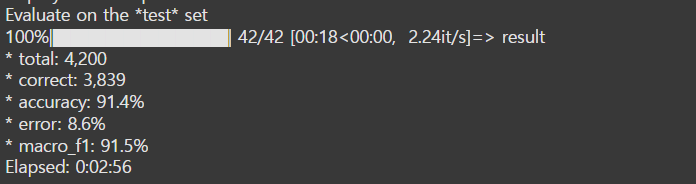

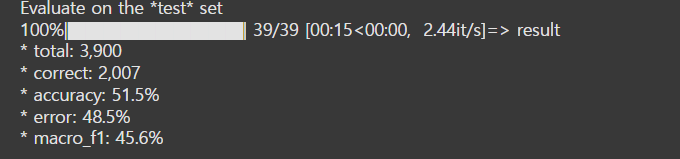

And this is the result from the CoCoopCLIP model. The one with existing classes, and the one below that is the problem with new classes.

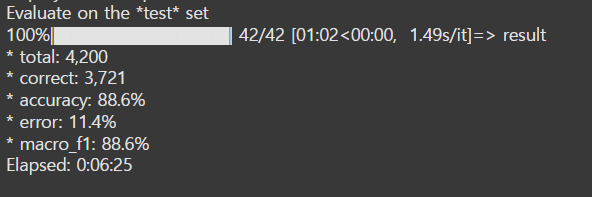

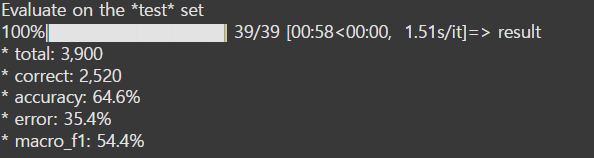

CoOp Modules are pretty good at catching details in the base cases. But CoCoOp would not perform as good as CoOp, because the module's context data is changed dynamically by the image features. In other words, when we put two modules in the case where all context is fixed, CoOp would perform better. That's the reason why CoOp outperformed its advanced model on the base case.

However, CoCoOp was not meant to beat CoOp in base situation- it was built for beat its predecessor in the case of new classes. In this case, this dynamic model would help classifier to generalize data, and infer new label's category more precisely than the predecessor. Hence, it's beating CoOp in this new situation with a massive gap of 11 percent point.